In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
#import open3d as o3
import numpy as np
import datetime
import os
import matplotlib.pyplot as plt
import h5py
import numpy as np
import pandas as pd
import cv2
import math
import keras.backend as K
import gc

from mpl_toolkits.mplot3d import Axes3D
from keras.layers import Input, Conv3D, BatchNormalization, MaxPool3D, Activation, Dropout, Dense, Flatten, MaxPooling3D, concatenate
from keras.optimizers import SGD, Adam, Adadelta, Adamax, Nadam
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.models import Model, load_model
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


In [3]:
# npzfile = np.load('data_generator/datasets/recognition/npz/dataset.npz')
npzfile = np.load('data_generator/datasets/recognition/npz/dataset.npz')

In [4]:
npzfile.files

['x_train',
 'y_train_c',
 'y_train_r',
 'x_test',
 'y_test_c',
 'y_test_r',
 'scale',
 'label']

In [5]:
x_train = None
y_train_c = None
x_test = None
y_test_c = None

In [6]:
x_train = npzfile['x_train']
y_train_c = npzfile['y_train_c']
x_test = npzfile['x_test']
y_test_c = npzfile['y_test_c']
label = npzfile['label']

In [7]:
label

array(['Armadillo', 'Bunny', 'Horse'], dtype='<U9')

In [8]:
# one hot encode
y_train_c = to_categorical(y_train_c)
y_test_c= to_categorical(y_test_c)
y_train_c.shape, y_test_c.shape

((60000, 3), (3000, 3))

In [9]:
np.max(x_train), np.min(x_train)

(159.203745625, 0.0)

In [10]:
scale = npzfile['scale'].tolist(); scale

159.203745625

In [11]:
x_train = x_train.astype(np.float32) / scale
x_test = x_test.astype(np.float32) / scale

In [12]:
x_train, x_dev, y_train_c, y_dev_c = train_test_split(x_train, y_train_c, test_size=0.2, random_state=1)

In [13]:
x_dev.shape, y_dev_c.shape

((12000, 12, 12, 12, 3), (12000, 3))

In [14]:
y_dev_c[0]

array([0., 0., 1.], dtype=float32)

In [15]:
y_dev_c[1]

array([1., 0., 0.], dtype=float32)

In [16]:
def cnn_model(input_shape=(12, 12, 12, 3)):
    inputs = Input(shape=input_shape)
    
    C1 = Conv3D(16, (5, 5, 5), padding='same', name='conv3d_1', kernel_initializer='glorot_normal')(inputs)
    C1 = BatchNormalization(name='batch_normalization_c1')(C1)
    C1 = Activation('relu')(C1)
    
    C1 = Conv3D(16, (3, 3, 3), padding='same', name='conv2d_2', kernel_initializer='glorot_normal')(C1)
    C1 = BatchNormalization(name='batch_normalization_c2')(C1)
    C1 = Activation('relu')(C1)   

    
    C2 = Conv3D(32, (5, 5, 5), padding='same', name='conv3d_3', kernel_initializer='glorot_normal')(C1)
    C2 = BatchNormalization(name='batch_normalization_c3')(C2)
    C2 = Activation('relu')(C2)   

    
    C2 = Conv3D(32, (3, 3, 3), padding='same', name='conv3d_4', kernel_initializer='glorot_normal')(C2)
    C2 = BatchNormalization(name='batch_normalization_c4')(C2)
    C2 = Activation('relu')(C2)    
  
    
    C2 = MaxPooling3D((2, 2, 2), strides=(2, 2, 2))(C2)
    
                             
    S4 = Flatten()(C2)
    
    FC5 = Dense(64, activation='relu', name='dense_1', kernel_initializer='glorot_normal')(S4)
    FC5 = BatchNormalization(name='batch_normalization_d1')(FC5)
    FC5 = Activation('relu')(FC5)
    
    
    Output = Dense(3, activation='softmax', name='dense_3', kernel_initializer='glorot_normal')(FC5)
    
    model = Model(inputs=inputs, outputs=Output)
    
    return model

In [17]:
model = cnn_model()

In [18]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 12, 12, 12, 3)     0         
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 12, 12, 12, 16)    6016      
_________________________________________________________________
batch_normalization_c1 (Batc (None, 12, 12, 12, 16)    64        
_________________________________________________________________
activation_1 (Activation)    (None, 12, 12, 12, 16)    0         
_________________________________________________________________
conv2d_2 (Conv3D)            (None, 12, 12, 12, 16)    6928      
_________________________________________________________________
batch_normalization_c2 (Batc (None, 12, 12, 12, 16)    64        
_________________________________________________________________
activation_2 (Activation)    (None, 12, 12, 12, 16)    0   

In [19]:
model.compile(optimizer=SGD(2e-2, decay= 1e-7, momentum=0.9, nesterov=True), loss='categorical_crossentropy', metrics=['accuracy'])
# model.compile(optimizer=Adam(3e-3, decay= 1e-7, amsgrad=True), loss='categorical_crossentropy', metrics=['accuracy'])

In [20]:
reduce_lr = [ReduceLROnPlateau(monitor='val_loss', factor=0.6 ,patience=3, min_lr=1e-6, verbose=True, cooldown=3)]

In [21]:
%%time
# history = model.fit(x = x_train, y = y_train_c, batch_size = 512, callbacks=reduce_lr, epochs=2, verbose=1, validation_data=(x_dev, y_dev_c), shuffle=True)
history = model.fit(x = x_train, y = y_train_c, batch_size = 128, callbacks=reduce_lr, epochs=2, verbose=1, shuffle=True)


Epoch 1/2
48000/48000 [==============================] - 39s 812us/step - loss: 0.0050 - accuracy: 0.9990
Epoch 2/2
  256/48000 [..............................] - ETA: 31s - loss: 6.5326e-04 - accuracy: 1.0000

C:\Users\dreamer\Anaconda3\lib\site-packages\keras\callbacks\callbacks.py:1042: RuntimeWarning: Reduce LR on plateau conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy,lr
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


48000/48000 [==============================] - 36s 748us/step - loss: 4.6229e-04 - accuracy: 1.0000
Wall time: 1min 18s


In [22]:
result_test = model.evaluate(x_test, y_test_c)
print('Accuracy of testing Set:',result_test[1])
print('Loss of testing set:', result_test[0])

3000/3000 [==============================] - 1s 477us/step
Accuracy of testing Set: 1.0
Loss of testing set: 0.00030706511639679474


In [23]:
model.save('models/recognition_assemble.h5')

In [24]:
starttime = datetime.datetime.now()
endtime = datetime.datetime.now()
y_pred = np.zeros(y_test_c.shape[0])

In [25]:
starttime = datetime.datetime.now()
y_pred = np.argmax(model.predict(x_test), axis=-1)
y_pred_str = label[y_pred]
endtime = datetime.datetime.now()

print("Prediction %d samples execute time: %s sec" % (x_test.shape[0], (endtime - starttime).total_seconds())) 
print("Average prediction execute time: %f ms" % ((endtime - starttime).total_seconds() / x_test.shape[0] * 1000)) 

Prediction 3000 samples execute time: 0.841603 sec
Average prediction execute time: 0.280534 ms


In [26]:
y_test_str = label[np.argmax(y_test_c, axis=-1)]

In [27]:
y_test_str

array(['Armadillo', 'Bunny', 'Bunny', ..., 'Bunny', 'Horse', 'Horse'],
      dtype='<U9')

In [28]:
y_pred

array([0, 1, 1, ..., 1, 2, 2], dtype=int64)

In [29]:
y_pred_str

array(['Armadillo', 'Bunny', 'Bunny', ..., 'Bunny', 'Horse', 'Horse'],
      dtype='<U9')

In [30]:
def show_result_3d(save=False):
    fig = plt.figure(figsize=(12,12))
    index = np.arange(x_test.shape[0])
    np.random.shuffle(index)
    index = index[:9]
    for i, idx in enumerate(index):
        data = x_test[idx].reshape(-1, 3)
        x = data[:, 0]
        y = data[:, 1]
        z = data[:, 2]
        
        ax = fig.add_subplot(3, 3, i+1, projection='3d')
        ax.scatter(x, y, z, c = 'r', marker = 'o')
        ax.set_title(f'{y_pred_str[idx]} / {y_test_str[idx]}')
    if save:
        plt.savefig('recognition_assemble_3d_result.png')

In [31]:
show_result_3d(save=True)

In [32]:
def show_result(save=False):
    fig = plt.figure(figsize=(12,12))
    index = np.arange(x_test.shape[0])
    np.random.shuffle(index)
    index = index[:9]
    for i, idx in enumerate(index):
        data = x_test[idx].reshape(-1, 3)
        x = data[:, 0]
        y = data[:, 1]
        z = data[:, 2]
        
        fig.add_subplot(3, 3, i+1)
        plt.scatter(x, y, c = 'r', marker = 'o')
        plt.title(f'{y_pred_str[idx]} / {y_test_str[idx]}')
    if save:
        plt.savefig('recognition_assemble_2d_result.png')

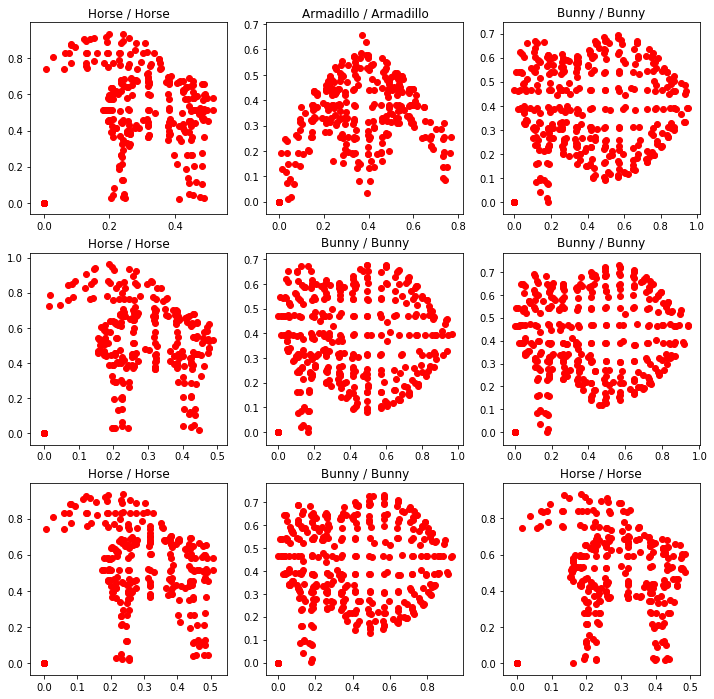

In [33]:
show_result(save=True)